In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import glob
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from PIL import Image
import random



Using TensorFlow backend.
/scratch/dsc381_2019/miniconda3/envs/p3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/scratch/dsc381_2019/miniconda3/envs/p3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/scratch/dsc381_2019/miniconda3/envs/p3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [6]:
df = pd.read_csv('labels.csv')
df = df[['Image', 'Category']]
df.Category.value_counts()

NEUTROPHIL                207
EOSINOPHIL                 88
LYMPHOCYTE                 33
MONOCYTE                   21
BASOPHIL                    3
NEUTROPHIL, NEUTROPHIL      3
NEUTROPHIL, EOSINOPHIL      2
EOSINOPHIL, LYMPHOCYTE      1
NEUTROPHIL,EOSINOPHIL       1
LYMPHOCYTE, LYMPHOCYTE      1
MONOCYTE, LYMPHOCYTE        1
EOSINOPHIL,EOSINOPHIL       1
NEUTROPHIL, MONOCYTE        1
NEUTROPHIL,BASOPHIL         1
EOSINOPHIL, EOSINOPHIL      1
NEUTROPHIL,NEUTROPHIL       1
NEUTROPHIL, LYMPHOCYTE      1
Name: Category, dtype: int64

In [7]:
# removing rows without labels
df_clean=df[df.Category.notnull()]
classes=list(df.Category.value_counts().head(4).index)
df_clean['classes'] = df_clean.Category.apply(lambda x: x in classes)
df_clean=df_clean[df_clean.classes == True]

/scratch/dsc381_2019/miniconda3/envs/p3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
def to_str(image_number):
    sn = str(image_number)
    if len(sn) == 1:
        return 'JPEGImages/BloodImage_0000'+sn+'.jpg'
    if len(sn) == 2:
        return 'JPEGImages/BloodImage_000'+sn+'.jpg'
    else:
        return 'JPEGImages/BloodImage_00'+sn+'.jpg'

In [9]:
df_clean['ImagePath']=df_clean.Image.apply(to_str)
imgdf = df_clean[['ImagePath','Category']]
imgdf.drop(index=[280],inplace = True)
imgdf.drop(index=[116],inplace = True)

/scratch/dsc381_2019/miniconda3/envs/p3.6/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Split train, validation, and test data 70-15-15

In [11]:
#  create folder to store train, val, and test data
new_dir = 'Train_Aug_only/test/NEUTROPHIL'
for i in ['train', 'validation', 'test']:
    for j in ['NEUTROPHIL','EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE']:
        new_dir = ('Train_Aug_only/{}/{}'.format(i,j))
        os.makedirs(new_dir)

In [12]:
images =list(glob.glob("JPEGImages/*.jpg"))


for clas in classes:
    print(clas)
    filenames = list(imgdf.ImagePath[imgdf.Category == clas].values)
    random.shuffle(filenames)
    if clas == 'NEUTROPHIL':
        split_1 = 30
        split_2 = 60
    elif clas == 'EOSINOPHIL':
        split_1 = 10
        split_2 = 20
    elif clas == 'LYMPHOCYTE':
        split_1 = 10
        split_2 = 20
    else:
        split_1 = 5
        split_2 = 10
                
    test_filenames = filenames[:split_1]
    dev_filenames = filenames[split_1:split_2]
    train_filenames = filenames[split_2:]
    
    for path in filenames:
        if path in train_filenames:
            img  = Image.open(path)
            img.save('Train_Aug_only/train/{}/{}_{}'.format(clas,clas,path[-7:]))
            
        elif path in dev_filenames:
            img  = Image.open(path)
            img.save('Train_Aug_only/validation/{}/{}_{}'.format(clas,clas,path[-7:]))
        else: 
            img  = Image.open(path)
            img.save('Train_Aug_only/test/{}/{}_{}'.format(clas,clas,path[-7:]))  

NEUTROPHIL
EOSINOPHIL
LYMPHOCYTE
MONOCYTE


# Augmentation

In [9]:
ratio_path = 'Train_Aug_only'
train_dataset_path = ratio_path + "/" + "train"
test_dataset_path = ratio_path + "/" + "test"
val_dataset_path = ratio_path + "/" + "validation"

IMG_SIZE      = 128
data_list     = os.listdir(train_dataset_path)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 32  
EPOCHS        = 25
CATEGORIES    = ['NEUTROPHIL','EOSINOPHIL','LYMPHOCYTE','MONOCYTE']

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        test_dataset_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        class_mode="categorical")

Found 237 images belonging to 4 classes.
Found 55 images belonging to 4 classes.


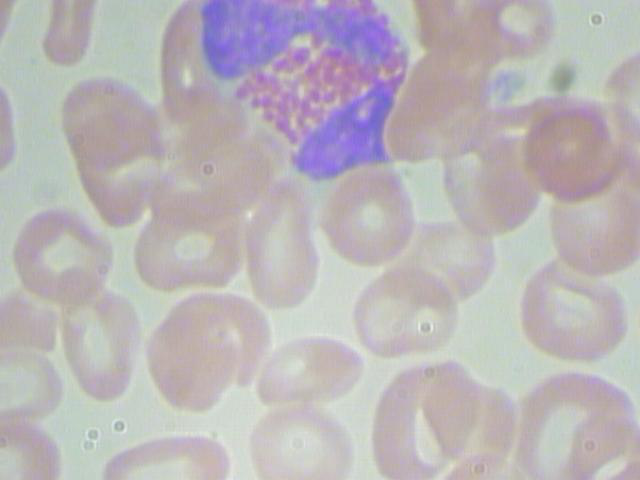

In [10]:
folder_path=train_dataset_path + '/' + 'EOSINOPHIL'
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
image_path = random.choice(images)
colorImage  = Image.open(image_path)
seed = random.choice([random.uniform(-25, 25), random.uniform(-25, 25), 
                       random.uniform(-25, 25), random.uniform(-25, 25), 
                       random.uniform(-25, 25), random.uniform(-25, 25), 
                      random.uniform(-25, 25), random.uniform(-25, 25), 180, 90])
rotated = colorImage.rotate(seed)
colorImage


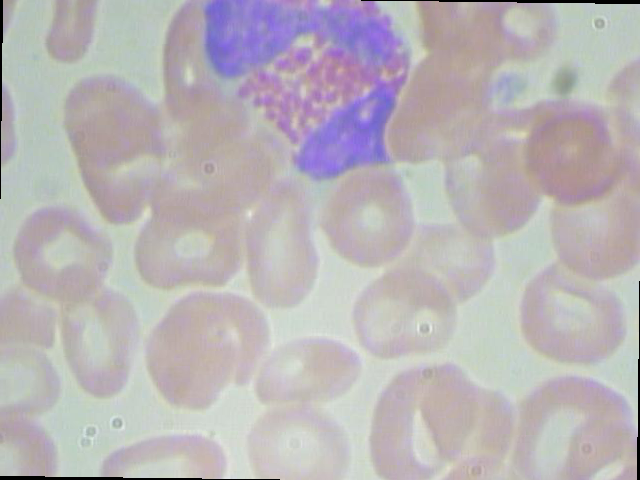

In [11]:
rotated

In [14]:
# augment train to 250 images. 
for ratio_path in ["Train_Aug_only"]:
    train_dataset_path = ratio_path + "/" + "train"
    val_dataset_path = ratio_path + "/" + "validation"

    for path in [train_dataset_path, val_dataset_path]:
        print(path)
        for category in CATEGORIES:
            print(category)
            folder_path = path + '/' + category
            images = [os.path.join(folder_path, f) 
                      for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
             
            if path == train_dataset_path:
                target_number = 249
            else: 
                continue
        
            num_files_desired = target_number - len(images)
            num_generated_files = 0
            while num_generated_files <= num_files_desired:
                image_path = random.choice(images)
                
                if image_path == folder_path + '/' + '.DS_Store':
                    continue
                    
                colorImage  = Image.open(image_path)
                seed = random.choice([random.uniform(-25, 25), random.uniform(-25, 25), 
                random.uniform(-25, 25), random.uniform(-25, 25), 
                random.uniform(-25, 25), random.uniform(-25, 25), 
                random.uniform(-25, 25), random.uniform(-25, 25), 180, 90])
                
                rotated = colorImage.rotate(seed)
                
                num_generated_files = num_generated_files + 1
                    
                new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

                    # write image to the disk
                rotated.save(new_file_path, 'JPEG')              

Train_Aug_only/train
NEUTROPHIL
EOSINOPHIL
LYMPHOCYTE
MONOCYTE
Train_Aug_only/validation
NEUTROPHIL
EOSINOPHIL
LYMPHOCYTE
MONOCYTE


In [15]:
# check image number
for ratio_path in ["Train_Aug_only"]:
    train_dataset_path = ratio_path + "/" + "train"
    test_dataset_path = ratio_path + "/" + "test"
    val_dataset_path = ratio_path + "/" + "validation"

    for path in [train_dataset_path, test_dataset_path, val_dataset_path]:
        print(path)
        for category in CATEGORIES:
            print(category)
            folder_path = path + '/' + category
            images = [os.path.join(folder_path, f) 
                      for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
            print(len(images))
           

Train_Aug_only/train
NEUTROPHIL
250
EOSINOPHIL
250
LYMPHOCYTE
250
MONOCYTE
250
Train_Aug_only/test
NEUTROPHIL
30
EOSINOPHIL
10
LYMPHOCYTE
10
MONOCYTE
5
Train_Aug_only/validation
NEUTROPHIL
30
EOSINOPHIL
10
LYMPHOCYTE
10
MONOCYTE
5
